# Translating Plate at 20°

In [1]:
using PyPlot
using VortexModel

function plot_system(sys)
    plate, sheet₊, sheet₋ = sys
    plot(real.(plate.zs[[1,N]]), imag.(plate.zs[[1,N]]), "k")
    plot(real.(getfield.(sheet₊.blobs, :z)), imag.(getfield.(sheet₊.blobs, :z)), linewidth = 1, color="#e41a1c")
    plot(real.(getfield.(sheet₋.blobs, :z)), imag.(getfield.(sheet₋.blobs, :z)), linewidth = 1, color="#377eb8")
    axis(:scaled)
end

plot_system (generic function with 1 method)

## Parameters

We are simulating a flat plate with zero thickness impulsively translating horizontally:

In [2]:
L = 2.0   # chord length
ċ = 0.5L  # translation velocity
α = π/9   # angle of attack

N = 128   # number of plate control points

Δt = 1e-2; # time step

We discretize the shear layers as vortex sheets, and assume that the Kutta condition is enforced at the trailing edge, and the suction parameter at the leading edge is kept below a critical value.

In [3]:
δ = 0.01
lesp = 0.1
tesp = 0.0

0.0

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [4]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
    
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Vortex.Plates.enforce_no_flow_through!(plate, (sheet₊, sheet₋))
    
    Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, segment₊, segment₋, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

We apply Fourier filtering to the sheet to redistribute the sheet's control points and supress small scale instabilities.

In [5]:
function filter_sheet!(sheet, Δs, Δf)
    if length(sheet) < 5
        return
    end
    zs = Vortex.position.(sheet.blobs)
    zs, (Γs,) = Vortex.Sheets.filter_by_arclength(zs, Δs, Δf, sheet.Γs)
    Vortex.Sheets.remesh!(sheet, zs, Γs)
end

filter_sheet! (generic function with 1 method)

## Initialization

We place the initial segments of the vortex sheet perpendicular to the edges of the plate

In [6]:
plate = Vortex.Plate(N, L, zero(Complex128), α, ċ)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

sys = (plate, sheet₊, sheet₋)
ẋs = Vortex.allocate_velocity(sys);

In [7]:
for t in 0.0:Δt:9.0
    
    Vortex.Plates.enforce_no_flow_through!(plate, (sheet₊, sheet₋))

    Vortex.reset_velocity!(ẋs, sys)
    Vortex.self_induce_velocity!(ẋs, sys)
    Vortex.advect!(sys, sys, ẋs, Δt)

    filter_sheet!(sheet₊, 3Δt, 6Δt)
    filter_sheet!(sheet₋, 3Δt, 6Δt)
     
    shed_new_vorticity!(sheet₊, sheet₋, plate, lesp, tesp)
end


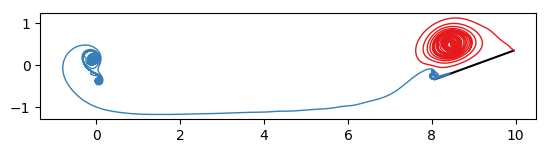

In [8]:
plot_system(sys);